 # Trabalho de Graduação para engenharia de Informação @UFABC
 Aluno: Lucas Ortega Venzel
 
 # Previsão do Índice Bovespa Utilizando Indicadores Técnicos e Algoritmos de Machine Learning

In [1]:
from yfinance import download
import pandas as pd
from ta import trend, momentum
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from pmdarima.arima import auto_arima
from tqdm import trange
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, confusion_matrix, mean_absolute_error, f1_score, accuracy_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score
from keras import backend as K
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Importando Dados e Criando Features

In [3]:
dataSP = download(
        tickers = '^GSPC',

        start='2006-01-01',
        interval = "1d",

        auto_adjust = True,
        prepost = True,
    )
dataUS = download(
        tickers = 'BRL=X',

        start='2006-01-01',
        interval = "1d",

        auto_adjust = True,
        prepost = True,
    )
dataBV = download(
        tickers = '^BVSP',

        start='2006-01-01',
        interval = "1d",

        auto_adjust = True,
        prepost = True,
    )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
dataSP.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,3335620000
2021-11-19,4708.439941,4717.750000,4694.220215,4697.959961,3265600000
2021-11-22,4712.000000,4743.830078,4682.169922,4682.939941,3206280000
2021-11-23,4678.479980,4699.390137,4652.660156,4690.700195,3428780000
2021-11-24,4675.779785,4694.750000,4659.890137,4687.240234,833163715


In [5]:
dataUS.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-18,5.5287,5.5646,5.475345,5.5287,0
2021-11-19,5.5561,5.5754,5.521700,5.5564,0
2021-11-22,5.6072,5.6144,5.563300,5.6116,0
2021-11-23,5.5858,5.6601,5.565159,5.5856,0
2021-11-24,5.6091,5.6226,5.548000,5.5972,0


In [6]:
dataBV.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-18,102948.000000,103757.00000,102014.000000,102524.000000,10905700
2021-11-19,102426.000000,103975.00000,102143.000000,103035.000000,11101500
2021-11-22,103036.000000,104613.00000,102122.000000,102122.000000,10410000
2021-11-23,102124.000000,103692.00000,101736.000000,103663.000000,13032400
2021-11-24,103651.882812,105041.15625,102464.289062,104461.382812,0


In [7]:
dataSP['ano'] = dataSP.index.year
dataUS['ano'] = dataUS.index.year
dataBV['ano'] = dataBV.index.year

In [8]:
temp = dataBV['Close']
temp.index = temp.index + pd.DateOffset(weeks=-1)
dataBV = dataBV.join(temp.rename('1w target'))
dataBV.loc[:, '1w target'] = dataBV['1w target'].fillna(method='ffill')
dataBV.loc[:, '1w target'] = (dataBV['1w target'] / dataBV['Close']) - 1

In [9]:
dataBV['1w target']

Date
2006-01-02    0.054615
2006-01-03    0.014707
2006-01-04    0.027141
2006-01-05    0.024130
2006-01-06    0.011896
                ...   
2021-11-18    0.018897
2021-11-19    0.013844
2021-11-22    0.022908
2021-11-23    0.007702
2021-11-24    0.000000
Name: 1w target, Length: 3915, dtype: float64

In [10]:
temp = dataBV['Close']
temp.index = temp.index + pd.DateOffset(weeks=-1)
dataBV = dataBV.join(temp.rename('1w absolute target'))
dataBV.loc[:, '1w absolute target'] = dataBV['1w absolute target'].fillna(method='ffill')

In [11]:
dataBV['1w absolute target']

Date
2006-01-02     35337.000000
2006-01-03     35049.000000
2006-01-04     35952.000000
2006-01-05     35779.000000
2006-01-06     35897.000000
                  ...      
2021-11-18    104461.382812
2021-11-19    104461.382812
2021-11-22    104461.382812
2021-11-23    104461.382812
2021-11-24    104461.382812
Name: 1w absolute target, Length: 3915, dtype: float64

In [12]:
dataSP['MACD'] = trend.MACD(close = dataSP['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False).macd_signal()
dataSP['RSI'] = momentum.RSIIndicator(close = dataSP['Close'], window = 14, fillna = False).rsi()
dataSP['ADX'] = trend.ADXIndicator(high = dataSP['High'], low = dataSP['Low'], close = dataSP['Close'], window = 14, fillna = False).adx()
dataSP['Aroon'] = trend.AroonIndicator(close = dataSP['Close'], window = 25, fillna = False).aroon_indicator()
dataSP['CCI'] = trend.CCIIndicator(high = dataSP['High'], low = dataSP['Low'], close = dataSP['Close'], window = 20, constant = 0.015, fillna = False).cci()
dataSP['DPO'] = trend.DPOIndicator(close = dataSP['Close'], window = 20, fillna = False).dpo()
dataSP['MI'] = trend.MassIndex(high = dataSP['Close'], low = dataSP['Low'], window_fast = 9, window_slow = 25, fillna = False).mass_index()
dataSP['TRIX'] = trend.TRIXIndicator(close = dataSP['Close'], window = 15, fillna = False).trix()

/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [13]:
dataSP.tail()

,Open,High,Low,Close,Volume,ano,MACD,RSI,ADX,Aroon,CCI,DPO,MI,TRIX
Date,,,,,,,,,,,,,,
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,3335620000,2021,57.864124,68.765198,31.778813,96.0,76.576651,17.328857,23.716047,0.194018
2021-11-19,4708.439941,4717.750000,4694.220215,4697.959961,3265600000,2021,57.081534,67.021687,31.768143,92.0,83.828588,29.166089,23.515338,0.191457
2021-11-22,4712.000000,4743.830078,4682.169922,4682.939941,3206280000,2021,55.809877,63.089475,32.276508,88.0,78.543133,40.812817,23.133289,0.187348
2021-11-23,4678.479980,4699.390137,4652.660156,4690.700195,3428780000,2021,54.294954,64.256314,31.612581,84.0,35.986874,39.187720,23.118986,0.182345
2021-11-24,4675.779785,4694.750000,4659.890137,4687.240234,833163715,2021,52.528020,63.295556,30.996077,76.0,29.158480,15.959521,23.298268,0.176452


In [14]:
dataUS['MACD'] = trend.MACD(close = dataUS['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False).macd_signal()
dataUS['RSI'] = momentum.RSIIndicator(close = dataUS['Close'], window = 14, fillna = False).rsi()
dataUS['ADX'] = trend.ADXIndicator(high = dataUS['High'], low = dataUS['Low'], close = dataUS['Close'], window = 14, fillna = False).adx()
dataUS['Aroon'] = trend.AroonIndicator(close = dataUS['Close'], window = 25, fillna = False).aroon_indicator()
dataUS['CCI'] = trend.CCIIndicator(high = dataUS['High'], low = dataUS['Low'], close = dataUS['Close'], window = 20, constant = 0.015, fillna = False).cci()
dataUS['DPO'] = trend.DPOIndicator(close = dataUS['Close'], window = 20, fillna = False).dpo()
dataUS['MI'] = trend.MassIndex(high = dataUS['Close'], low = dataUS['Low'], window_fast = 9, window_slow = 25, fillna = False).mass_index()
dataUS['TRIX'] = trend.TRIXIndicator(close = dataUS['Close'], window = 15, fillna = False).trix()

/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [15]:
dataUS.tail()

,Open,High,Low,Close,Volume,ano,MACD,RSI,ADX,Aroon,CCI,DPO,MI,TRIX
Date,,,,,,,,,,,,,,
2021-11-18,5.5287,5.5646,5.475345,5.5287,0,2021,0.014436,51.534190,21.261128,-32.0,-34.423227,0.12123,25.857113,0.043791
2021-11-19,5.5561,5.5754,5.521700,5.5564,0,2021,0.011886,53.892334,20.249110,-32.0,1.422287,0.00010,25.613004,0.034885
2021-11-22,5.6072,5.6144,5.563300,5.6116,0,2021,0.011307,58.251664,19.900950,-32.0,54.409115,0.05128,25.650528,0.030710
2021-11-23,5.5858,5.6601,5.565159,5.5856,0,2021,0.011555,55.585853,20.188877,-32.0,58.663904,-0.01088,25.753366,0.028899
2021-11-24,5.6091,5.6226,5.548000,5.5972,0,2021,0.012467,56.541430,20.108512,-32.0,40.720398,-0.01050,25.770614,0.029102


In [16]:
dataBV['MACD'] = trend.MACD(close = dataBV['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False).macd_signal()
dataBV['RSI'] = momentum.RSIIndicator(close = dataBV['Close'], window = 14, fillna = False).rsi()
dataBV['ADX'] = trend.ADXIndicator(high = dataBV['High'], low = dataBV['Low'], close = dataBV['Close'], window = 14, fillna = False).adx()
dataBV['Aroon'] = trend.AroonIndicator(close = dataBV['Close'], window = 25, fillna = False).aroon_indicator()
dataBV['CCI'] = trend.CCIIndicator(high = dataBV['High'], low = dataBV['Low'], close = dataBV['Close'], window = 20, constant = 0.015, fillna = False).cci()
dataBV['DPO'] = trend.DPOIndicator(close = dataBV['Close'], window = 20, fillna = False).dpo()
dataBV['MI'] = trend.MassIndex(high = dataBV['Close'], low = dataBV['Low'], window_fast = 9, window_slow = 25, fillna = False).mass_index()
dataBV['TRIX'] = trend.TRIXIndicator(close = dataBV['Close'], window = 15, fillna = False).trix()

/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/lvenzel/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [17]:
dataBV.tail()

,Open,High,Low,Close,Volume,ano,1w target,1w absolute target,MACD,RSI,ADX,Aroon,CCI,DPO,MI,TRIX
Date,,,,,,,,,,,,,,,,
2021-11-18,102948.000000,103757.00000,102014.000000,102524.000000,10905700,2021,0.018897,104461.382812,-1984.456540,36.528517,37.740472,-84.0,-134.329684,-2478.200000,24.683949,-0.261679
2021-11-19,102426.000000,103975.00000,102143.000000,103035.000000,11101500,2021,0.013844,104461.382812,-1989.876973,38.337778,37.581818,-84.0,-121.862309,-46.300000,24.590386,-0.263001
2021-11-22,103036.000000,104613.00000,102122.000000,102122.000000,10410000,2021,0.022908,104461.382812,-2006.627821,36.344378,36.967428,-92.0,-121.995143,452.900000,24.253952,-0.265578
2021-11-23,102124.000000,103692.00000,101736.000000,103663.000000,13032400,2021,0.007702,104461.382812,-2000.442981,41.841058,36.551543,-92.0,-108.176002,-1548.500000,24.319116,-0.265649
2021-11-24,103651.882812,105041.15625,102464.289062,104461.382812,0,2021,0.000000,104461.382812,-1962.909569,44.514298,35.201249,-88.0,-52.910149,-44.769141,24.463882,-0.262094


In [83]:
scaler = StandardScaler()
features = ['MACD', 'RSI', 'ADX', 'Aroon', 'CCI', 'DPO', 'MI', 'TRIX']
for i in features:
  dataSP[i] = scaler.fit_transform(dataSP[i].values.reshape(-1, 1))
  dataUS[i] = scaler.fit_transform(dataUS[i].values.reshape(-1, 1))
  dataBV[i] = scaler.fit_transform(dataBV[i].values.reshape(-1, 1))

In [18]:
dataSP = dataSP.add_prefix('SP_')
dataUS = dataUS.add_prefix('US_')
dataBV = dataBV.add_prefix('BV_')

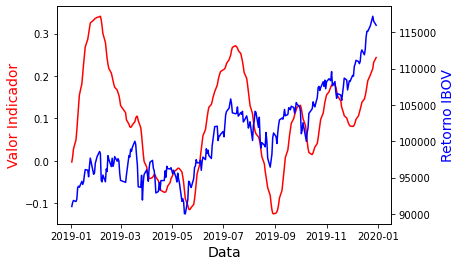

In [50]:
# dataBV.loc[dataBV.index.year == 2019,'BV_MACD'].plot()
# plt.figure()
# dataBV.loc[dataBV.index.year == 2019,'BV_1w target'].plot()
# create figure and axis objects with subplots()

fig,ax = plt.subplots()
# make a plot
ax.plot(dataBV.loc[dataBV.index.year == 2019,'BV_MACD'].index, dataBV.loc[dataBV.index.year == 2019,'BV_TRIX'], color="red")
# set x-axis label
ax.set_xlabel("Data",fontsize=14)
# set y-axis label
ax.set_ylabel("Valor Indicador",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dataBV.loc[dataBV.index.year == 2019,'BV_1w target'].index, dataBV.loc[dataBV.index.year == 2019,'BV_Close'],color="blue")
ax2.set_ylabel("Retorno IBOV",color="blue",fontsize=14)
plt.show()
# save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [85]:
data = pd.merge(left=dataBV, right=dataSP, how='left', left_index=True, right_index=True)

In [86]:
data = pd.merge(left=data, right=dataUS, how='left', left_index=True, right_index=True)

In [87]:
data = data.fillna(axis='index', method='ffill')

In [88]:
allFeatures = ['BV_' + x for x in features] + ['US_' + x for x in features] + ['SP_' + x for x in features]

In [89]:
negociation = ['Open', 'High', 'Low', 'Close']
allData = ['BV_' + x for x in negociation] + ['US_' + x for x in negociation] + ['SP_' + x for x in negociation]

<AxesSubplot:xlabel='Date'>

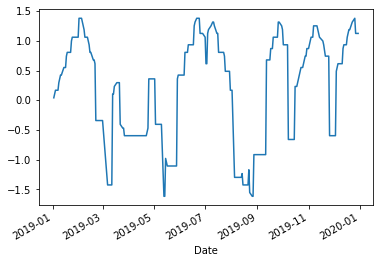

In [135]:
# 'MACD', 'RSI', 'ADX', 'Aroon', 'CCI', 'DPO', 'MI', 'TRIX']
data.loc[data.index.year == 2019 , 'BV_Aroon'].plot()

## ARIMA

### Using Technical Features

In [97]:
predictions_arima = {}
auto_fitted = {}

for i in trange(2016,2022):

  X_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), allFeatures]
  y_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), 'BV_1w target']

  X_valid = data.loc[data.index.year == i - 1, allFeatures]
  y_valid = data.loc[data.index.year == i - 1, 'BV_1w target']

  X_test = data.loc[data.index.year == i, allFeatures]
  y_test = data.loc[data.index.year == i, 'BV_1w target']

  auto_fitted[i] = auto_arima(y=y_train, start_p=0, start_q=0, max_p=10, max_q=10, n_jobs=-1, test='adf')
  predictions_arima[i] = pd.DataFrame(auto_fitted[i].predict(len(X_test), X_test[allFeatures]), index=X_test.index, columns=['Predictions'])
  predictions_arima[i]['True'] = y_test

  0%|          | 0/6 [00:00<?, ?it/s]/home/lvenzel/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
 17%|█▋        | 1/6 [00:15<01:15, 15.01s/it]/home/lvenzel/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
 33%|███▎      | 2/6 [02:07<04:48, 72.06s/it]/home/lvenzel/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
 50%|█████     | 3/6 [04:06<04:41, 93.88s/it]/home/lvenzel/anaconda3/

In [98]:
print(auto_fitted[2016].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1731
Model:               SARIMAX(6, 0, 0)   Log Likelihood                4097.857
Date:                Wed, 17 Nov 2021   AIC                          -8181.714
Time:                        22:10:54   BIC                          -8143.519
Sample:                             0   HQIC                         -8167.587
                               - 1731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8560      0.014     59.236      0.000       0.828       0.884
ar.L2          0.0110      0.020      0.560      0.576      -0.028       0.050
ar.L3         -0.0824      0.019     -4.336      0.0

In [99]:
for i in predictions_arima.keys():
  print(i)
  print('  ARIMA R²: {}'.format(r2_score(predictions_arima[i]['True'],predictions_arima[i]['Predictions'])))
  print('  ARIMA MAE: {}'.format(mean_absolute_error(predictions_arima[i]['True'],predictions_arima[i]['Predictions'])))
  print('  ARIMA MSE: {}'.format(mean_squared_error(predictions_arima[i]['True'],predictions_arima[i]['Predictions'])))

2016
  ARIMA R²: -0.03476304897471083
  ARIMA MAE: 0.029162941738576642
  ARIMA MSE: 0.001417540087359177
2017
  ARIMA R²: -0.05686759067573077
  ARIMA MAE: 0.020215127836925664
  ARIMA MSE: 0.0006477617152177684
2018
  ARIMA R²: -0.009977133990809683
  ARIMA MAE: 0.02297214864723402
  ARIMA MSE: 0.0008521001419671584
2019
  ARIMA R²: -0.028148090959849492
  ARIMA MAE: 0.018551596575525724
  ARIMA MSE: 0.0005162661341870973
2020
  ARIMA R²: -0.006732913843240151
  ARIMA MAE: 0.03444899211786769
  ARIMA MSE: 0.002919528352612741
2021
  ARIMA R²: -0.0037942981616343463
  ARIMA MAE: 0.018143481289848176
  ARIMA MSE: 0.0005443765921456017


In [100]:
classification_arima = {}
for i in predictions_arima.keys():
  classification_arima[i] = predictions_arima[i].applymap(lambda x: 0 if x < 0 else 1)

In [101]:
for i in classification_arima.keys():
  print(i)
  print('  ARIMA F1: {}'.format(f1_score(classification_arima[i]['True'],classification_arima[i]['Predictions'])))
  print('  ARIMA Accu: {}'.format(accuracy_score(classification_arima[i]['True'],classification_arima[i]['Predictions'])))
  print('  ARIMA precision: {}'.format(precision_score(classification_arima[i]['True'],classification_arima[i]['Predictions'])))
  print('  ARIMA Recall: {}'.format(recall_score(classification_arima[i]['True'],classification_arima[i]['Predictions'])))

2016
  ARIMA F1: 0.5342960288808665
  ARIMA Accu: 0.4819277108433735
  ARIMA precision: 0.5967741935483871
  ARIMA Recall: 0.48366013071895425
2017
  ARIMA F1: 0.5407407407407406
  ARIMA Accu: 0.4979757085020243
  ARIMA precision: 0.5934959349593496
  ARIMA Recall: 0.4965986394557823
2018
  ARIMA F1: 0.5307692307692308
  ARIMA Accu: 0.5
  ARIMA precision: 0.5564516129032258
  ARIMA Recall: 0.5073529411764706
2019
  ARIMA F1: 0.5563380281690141
  ARIMA Accu: 0.4898785425101215
  ARIMA precision: 0.6422764227642277
  ARIMA Recall: 0.4906832298136646
2020
  ARIMA F1: 0.5543071161048688
  ARIMA Accu: 0.5182186234817814
  ARIMA precision: 0.6166666666666667
  ARIMA Recall: 0.5034013605442177
2021
  ARIMA F1: 0.6179401993355482
  ARIMA Accu: 0.44711538461538464
  ARIMA precision: 0.44711538461538464
  ARIMA Recall: 1.0


In [102]:
for i in classification_arima.keys():
  classification_arima[i]['week'] = classification_arima[i].index.week
  classification_arima[i]['True'] = predictions_arima[i]['True'] + 1
  result = classification_arima[i].groupby('week', as_index=False).first()
  patrimonio = 100
  patrimonio2 = 100
  for j in result.index:
    if result.loc[j, 'Predictions'] == 1:
      patrimonio *= result.loc[j, 'True']
      patrimonio2 *= result.loc[j, 'True']
    else:
      patrimonio2 *= 2 - result.loc[j, 'True']
  print('{}: patrimonio final long-only: {}, long-short: {}'.format(i, patrimonio, patrimonio2))

<ipython-input-102-0d54598ab2fe>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  classification_arima[i]['week'] = classification_arima[i].index.week


2016: patrimonio final long-only: 170.2832727059861, long-short: 200.05158765443147
2017: patrimonio final long-only: 124.43337058190613, long-short: 124.76622129036447
2018: patrimonio final long-only: 112.62001011100442, long-short: 105.14391959092588
2019: patrimonio final long-only: 122.45916101553493, long-short: 112.06531099341234
2020: patrimonio final long-only: 77.02732187843421, long-short: 52.07456409123568
2021: patrimonio final long-only: 87.86583709648168, long-short: 87.86583709648168


## Gradient Boost Regressor

In [103]:
predictions_GBR = {}
GBR = {}
for i in trange(2016,2022):
  X_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), allFeatures]
  y_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), 'BV_1w target']

  X_valid = data.loc[data.index.year == i - 1, allFeatures]
  y_valid = data.loc[data.index.year == i - 1, 'BV_1w target']

  X_test = data.loc[data.index.year == i, allFeatures]
  y_test = data.loc[data.index.year == i, 'BV_1w target']

  def objective(trial):
    loss = trial.suggest_categorical('loss', ['ls', 'lad', 'huber', 'quantile'])
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])


    regressor_obj = GradientBoostingRegressor(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, criterion=criterion,
                                              min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth, max_features=max_features) 
    regressor_obj.fit(X_train, y_train)
    score = r2_score(y_valid, regressor_obj.predict(X_valid))
    return score


  study = optuna.create_study(direction="maximize")
  study.optimize(objective, n_trials=50)

  GBR[i] = GradientBoostingRegressor(**study.best_params)
  GBR[i].fit(X_train, y_train)
  predictions_GBR[i] = pd.DataFrame(GBR[i].predict(X_test), index=X_test.index, columns=['Predictions'])
  predictions_GBR[i]['True'] = y_test

  0%|          | 0/6 [00:00<?, ?it/s][I 2021-11-17 22:10:55,202] A new study created in memory with name: no-name-59e27c41-0d71-428e-9c20-e0b69acd056c
[I 2021-11-17 22:10:56,647] Trial 0 finished with value: -0.0084579985372919 and parameters: {'loss': 'lad', 'learning_rate': 1.4249170093325433e-05, 'n_estimators': 293, 'subsample': 0.34623017275126167, 'criterion': 'friedman_mse', 'min_samples_split': 30, 'min_samples_leaf': 4, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 0 with value: -0.0084579985372919.
[I 2021-11-17 22:10:58,727] Trial 1 finished with value: -0.08322081962436267 and parameters: {'loss': 'lad', 'learning_rate': 0.0064645344274017165, 'n_estimators': 447, 'subsample': 0.5034030313696921, 'criterion': 'friedman_mse', 'min_samples_split': 50, 'min_samples_leaf': 8, 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.0084579985372919.
[I 2021-11-17 22:11:00,747] Trial 2 finished with value: -0.008637475533395778 and parameters: {'loss': 'h

In [104]:
for i in predictions_GBR.keys():
  print(i)
  print('  GBR R²: {}'.format(r2_score(predictions_GBR[i]['True'],predictions_GBR[i]['Predictions'])))
  print('  GBR MAE: {}'.format(mean_absolute_error(predictions_GBR[i]['True'],predictions_GBR[i]['Predictions'])))
  print('  GBR MSE: {}'.format(mean_squared_error(predictions_GBR[i]['True'],predictions_GBR[i]['Predictions'])))

2016
  GBR R²: -0.04943796320338367
  GBR MAE: 0.029401930623689558
  GBR MSE: 0.0014376435102812781
2017
  GBR R²: -0.019829543936647598
  GBR MAE: 0.019776789457596092
  GBR MSE: 0.0006250608311186689
2018
  GBR R²: 0.001274594831239373
  GBR MAE: 0.022888868560964344
  GBR MSE: 0.000842607254055172
2019
  GBR R²: -0.014011098184658843
  GBR MAE: 0.01849635837719279
  GBR MSE: 0.0005091674966724714
2020
  GBR R²: 0.026161120302075846
  GBR MAE: 0.03403599062515954
  GBR MSE: 0.0028241355587559826
2021
  GBR R²: -0.0513300910143053
  GBR MAE: 0.01878277382724996
  GBR MSE: 0.000570156149735706


In [105]:
classification_GBR = {}
for i in predictions_GBR.keys():
  classification_GBR[i] = predictions_GBR[i].applymap(lambda x: 0 if x < 0 else 1)

In [106]:
for i in classification_GBR.keys():
  print(i)
  print('  GBRclassification_GBR F1: {}'.format(f1_score(classification_GBR[i]['True'],classification_GBR[i]['Predictions'])))
  print('  GBRclassification_GBR Accu: {}'.format(accuracy_score(classification_GBR[i]['True'],classification_GBR[i]['Predictions'])))
  print('  GBRclassification_GBR Precision: {}'.format(precision_score(classification_GBR[i]['True'],classification_GBR[i]['Predictions'])))
  print('  GBRclassification_GBR Recall: {}'.format(recall_score(classification_GBR[i]['True'],classification_GBR[i]['Predictions'])))

2016
  GBRclassification_GBR F1: 0.0
  GBRclassification_GBR Accu: 0.3855421686746988
  GBRclassification_GBR Precision: 0.0
  GBRclassification_GBR Recall: 0.0
2017
  GBRclassification_GBR F1: 0.5542168674698795
  GBRclassification_GBR Accu: 0.5506072874493927
  GBRclassification_GBR Precision: 0.6764705882352942
  GBRclassification_GBR Recall: 0.46938775510204084
2018
  GBRclassification_GBR F1: 0.5641025641025642
  GBRclassification_GBR Accu: 0.5122950819672131
  GBRclassification_GBR Precision: 0.5620437956204379
  GBRclassification_GBR Recall: 0.5661764705882353
2019
  GBRclassification_GBR F1: 0.5963636363636364
  GBRclassification_GBR Accu: 0.5506072874493927
  GBRclassification_GBR Precision: 0.7192982456140351
  GBRclassification_GBR Recall: 0.5093167701863354
2020
  GBRclassification_GBR F1: 0.6382978723404255
  GBRclassification_GBR Accu: 0.5870445344129555
  GBRclassification_GBR Precision: 0.6666666666666666
  GBRclassification_GBR Recall: 0.6122448979591837
2021
  GBRclas

/home/lvenzel/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
for i in classification_GBR.keys():
  classification_GBR[i]['week'] = classification_GBR[i].index.week
  classification_GBR[i]['True'] = predictions_GBR[i]['True'] + 1
  result = classification_GBR[i].groupby('week', as_index=False).first()
  patrimonio = 100
  patrimonio2 = 100
  for j in result.index:
    if result.loc[j, 'Predictions'] == 1:
      patrimonio *= result.loc[j, 'True']
      patrimonio2 *= result.loc[j, 'True']
    else:
      patrimonio2 *= 2 - result.loc[j, 'True']
  print('{}: patrimonio final long-only: {}, long-short: {}'.format(i, patrimonio, patrimonio2))

2016: patrimonio final long-only: 100, long-short: 65.04940187414854
2017: patrimonio final long-only: 109.75235263670902, long-short: 97.49406959703715
2018: patrimonio final long-only: 129.64925599620335, long-short: 139.83195078411205
2019: patrimonio final long-only: 134.57891689776687, long-short: 135.7854435781594
2020: patrimonio final long-only: 126.08868974354598, long-short: 142.06624634008762
2021: patrimonio final long-only: 97.62595896568956, long-short: 107.96518875818715


<ipython-input-107-0e171d6e8f08>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  classification_GBR[i]['week'] = classification_GBR[i].index.week


In [108]:
predictions_MLP = {}
model = {}
for i in range(2016,2022):

  X_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), allFeatures]
  y_train = data.loc[(data.index.year >= i - 8) & (data.index.year < i - 1), 'BV_1w target']

  X_valid = data.loc[data.index.year == i - 1, allFeatures]
  y_valid = data.loc[data.index.year == i - 1, 'BV_1w target']

  X_test = data.loc[data.index.year == i, allFeatures]
  y_test = data.loc[data.index.year == i, 'BV_1w target']


  model[i] = tf.keras.models.Sequential()
  model[i].add(tf.keras.layers.Dense(units=X_train.shape[1], input_dim = X_train.shape[1], activation='sigmoid'))
  model[i].add(tf.keras.layers.Dropout(0.1))
  model[i].add(tf.keras.layers.Dense(units=12,  activation = 'sigmoid'))
  model[i].add(tf.keras.layers.Dropout(0.1))
  model[i].add(tf.keras.layers.Dense(units=6,  activation = 'sigmoid'))
  model[i].add(tf.keras.layers.Dropout(0.1))
  model[i].add(tf.keras.layers.Dense(1,  activation = 'linear'))

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, 
                                   verbose=1, mode='max', min_lr=0.000000001)
  
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200) 

  model[i].compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=coeff_determination)

  model[i].fit(X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=500,
            batch_size=100,
            shuffle=1,
            callbacks = [reduce_lr, earlystop],
            verbose=1)
  predictions_MLP[i] = pd.DataFrame(model[i].predict(X_test), index=X_test.index, columns=['Predictions'])
  predictions_MLP[i]['True'] = y_test

Epoch 1/500
18/18 [==============================] - 0s 7ms/step - loss: 0.1007 - coeff_determination: -73.3016 - val_loss: 0.0012 - val_coeff_determination: -0.3481 - lr: 0.0100
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0380 - coeff_determination: -26.7053 - val_loss: 0.0016 - val_coeff_determination: -0.8125 - lr: 0.0100
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0245 - coeff_determination: -16.7426 - val_loss: 0.0012 - val_coeff_determination: -0.4414 - lr: 0.0100
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0180 - coeff_determination: -12.2702 - val_loss: 0.0010 - val_coeff_determination: -0.1322 - lr: 0.0100
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0125 - coeff_determination: -7.6902 - val_loss: 0.0011 - val_coeff_determination: -0.2073 - lr: 0.0100
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0086 - coeff_determination: -5.

In [109]:
for i in predictions_MLP.keys():
  print(i)
  print('  MLP R²: {}'.format(r2_score(predictions_MLP[i]['True'],predictions_MLP[i]['Predictions'])))
  print('  MLP MAE: {}'.format(mean_absolute_error(predictions_MLP[i]['True'],predictions_MLP[i]['Predictions'])))
  print('  MLP MSE: {}'.format(mean_squared_error(predictions_MLP[i]['True'],predictions_MLP[i]['Predictions'])))

2016
  MLP R²: -0.05594158107159042
  MLP MAE: 0.029505952615166343
  MLP MSE: 0.0014465529307038406
2017
  MLP R²: -0.04511663854031478
  MLP MAE: 0.01994083338940216
  MLP MSE: 0.0006405594724980232
2018
  MLP R²: 0.0013363002613050456
  MLP MAE: 0.02289047630432245
  MLP MSE: 0.0008425551942570343
2019
  MLP R²: -0.02706835409136832
  MLP MAE: 0.01864204758289544
  MLP MSE: 0.0005157239636730135
2020
  MLP R²: 0.001261410590472467
  MLP MAE: 0.03359681166046833
  MLP MSE: 0.002896344788706889
2021
  MLP R²: -0.018414271148470274
  MLP MAE: 0.01843628828703952
  MLP MSE: 0.0005523052794139099


In [110]:
classification_MLP = {}
for i in predictions_MLP.keys():
  classification_MLP[i] = predictions_MLP[i].applymap(lambda x: 0 if x < 0 else 1)

In [111]:
for i in classification_MLP.keys():
  print(i)
  print('  MLP F1: {}'.format(f1_score(classification_MLP[i]['True'],classification_MLP[i]['Predictions'])))
  print('  MLP Accu: {}'.format(accuracy_score(classification_MLP[i]['True'],classification_MLP[i]['Predictions'])))
  print('  MLP precision: {}'.format(precision_score(classification_MLP[i]['True'],classification_MLP[i]['Predictions'])))
  print('  MLP recall: {}'.format(recall_score(classification_MLP[i]['True'],classification_MLP[i]['Predictions'])))

2016
  MLP F1: 0.4032921810699588
  MLP Accu: 0.41767068273092367
  MLP precision: 0.5444444444444444
  MLP recall: 0.3202614379084967
2017
  MLP F1: 0.3033707865168539
  MLP Accu: 0.4979757085020243
  MLP precision: 0.8709677419354839
  MLP recall: 0.1836734693877551
2018
  MLP F1: 0.5338345864661654
  MLP Accu: 0.4918032786885246
  MLP precision: 0.5461538461538461
  MLP recall: 0.5220588235294118
2019
  MLP F1: 0.53125
  MLP Accu: 0.5141700404858299
  MLP precision: 0.7157894736842105
  MLP recall: 0.422360248447205
2020
  MLP F1: 0.7461928934010152
  MLP Accu: 0.5951417004048583
  MLP precision: 0.5951417004048583
  MLP recall: 1.0
2021
  MLP F1: 0.5333333333333333
  MLP Accu: 0.5625
  MLP precision: 0.5098039215686274
  MLP recall: 0.5591397849462365


In [112]:
for i in classification_MLP.keys():
  classification_MLP[i]['week'] = classification_MLP[i].index.week
  classification_MLP[i]['True'] = predictions_MLP[i]['True'] + 1
  result = classification_MLP[i].groupby('week', as_index=False).first()
  patrimonio = 100
  patrimonio2 = 100
  for j in result.index:
    if result.loc[j, 'Predictions'] == 1:
      patrimonio *= result.loc[j, 'True']
      patrimonio2 *= result.loc[j, 'True']
    else:
      patrimonio2 *= 2 - result.loc[j, 'True']
  print('{}: patrimonio final long-only: {}, long-short: {}'.format(i, patrimonio, patrimonio2))

2016: patrimonio final long-only: 88.77457115503086, long-short: 52.5774933931971
2017: patrimonio final long-only: 112.68068226894087, long-short: 101.26024772048723
2018: patrimonio final long-only: 113.40443492481492, long-short: 105.60372906605878
2019: patrimonio final long-only: 129.4756982158322, long-short: 125.16972688176169
2020: patrimonio final long-only: 106.78916627093129, long-short: 106.78916627093129
2021: patrimonio final long-only: 101.16003327536838, long-short: 114.68713205358931


<ipython-input-112-f341c5515776>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  classification_MLP[i]['week'] = classification_MLP[i].index.week


In [113]:
lookback = 50
data_lstm = pd.DataFrame(columns=allFeatures + ['BV_1w target'], dtype=object)
for index in data.index[50:]:
  for column in data[allFeatures + ['BV_1w target']].columns:
    position = data.index.get_loc(index)
    data_lstm.at[index, column] = data[column].iloc[position - 49: position + 1].tolist()

In [114]:
predictions_LSTM = {}
model = {}
for i in range(2016,2022):

  X_train = data_lstm.loc[(data_lstm.index.year >= i - 8) & (data_lstm.index.year < i - 1), allFeatures]
  X_train = np.array([X_train[column].tolist() for column in X_train.columns])
  X_train = X_train.reshape(X_train.shape[1], X_train.shape[2], X_train.shape[0])
  y_train = data_lstm.loc[(data_lstm.index.year >= i - 8) & (data_lstm.index.year < i - 1), 'BV_1w target'].tolist()

  X_valid = data_lstm.loc[data_lstm.index.year == i - 1, allFeatures]
  X_valid = np.array([X_valid[column].tolist() for column in X_valid.columns])
  X_valid = X_valid.reshape(X_valid.shape[1], X_valid.shape[2], X_valid.shape[0])
  y_valid = data_lstm.loc[data_lstm.index.year == i - 1, 'BV_1w target'].tolist()

  X_test = data_lstm.loc[data_lstm.index.year == i, allFeatures]
  X_test = np.array([X_test[column].tolist() for column in X_test.columns])
  X_test = X_test.reshape(X_test.shape[1], X_test.shape[2], X_test.shape[0])
  y_test = data_lstm.loc[data_lstm.index.year == i, 'BV_1w target'].tolist()


  model[i] = tf.keras.models.Sequential()
  model[i].add(tf.keras.layers.LSTM(units=len(allFeatures), input_shape=(None, len(allFeatures)), return_sequences=True))
  model[i].add(tf.keras.layers.Dropout(0.1))
  model[i].add(tf.keras.layers.LSTM(units=6,  activation = 'sigmoid', return_sequences=True))
  model[i].add(tf.keras.layers.Dropout(0.1))
  model[i].add(tf.keras.layers.Dense(1,  activation = 'linear'))

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                                   verbose=1, mode='max', min_lr=0.000000001)
  
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50) 

  model[i].compile(tf.keras.optimizers.Adam(learning_rate=0.1), loss='mse', metrics=coeff_determination)
  model[i].fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train),
            validation_data=(tf.convert_to_tensor(X_valid), tf.convert_to_tensor(y_valid)),
            epochs=300,
            batch_size=200,
            shuffle=1,
            callbacks= [reduce_lr, earlystop],
            verbose=1)
  predictions_LSTM[i] = pd.DataFrame(model[i].predict(X_test)[:, -1], index=data.loc[data.index.year == i].index, columns=['Predictions'])
  predictions_LSTM[i]['True'] = np.array(y_test)[:, -1]

Epoch 1/300
9/9 [==============================] - 2s 74ms/step - loss: 0.1157 - coeff_determination: -73.0774 - val_loss: 0.0056 - val_coeff_determination: -3.9664 - lr: 0.1000
Epoch 2/300
9/9 [==============================] - 0s 30ms/step - loss: 0.0060 - coeff_determination: -3.0137 - val_loss: 0.0019 - val_coeff_determination: -0.7488 - lr: 0.1000
Epoch 3/300
9/9 [==============================] - 0s 29ms/step - loss: 0.0036 - coeff_determination: -1.4033 - val_loss: 0.0014 - val_coeff_determination: -0.3146 - lr: 0.1000
Epoch 4/300
9/9 [==============================] - 0s 31ms/step - loss: 0.0024 - coeff_determination: -0.6460 - val_loss: 0.0012 - val_coeff_determination: -0.1223 - lr: 0.1000
Epoch 5/300
9/9 [==============================] - 0s 30ms/step - loss: 0.0019 - coeff_determination: -0.3176 - val_loss: 0.0012 - val_coeff_determination: -0.0657 - lr: 0.1000
Epoch 6/300
9/9 [==============================] - 0s 32ms/step - loss: 0.0017 - coeff_determination: -0.1665 - va

In [121]:
model[i].summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, None, 24)          4704      
                                                                 
 dropout_53 (Dropout)        (None, None, 24)          0         
                                                                 
 lstm_21 (LSTM)              (None, None, 6)           744       
                                                                 
 dropout_54 (Dropout)        (None, None, 6)           0         
                                                                 
 dense_54 (Dense)            (None, None, 1)           7         
                                                                 
Total params: 5,455
Trainable params: 5,455
Non-trainable params: 0
_________________________________________________________________


In [115]:
for i in predictions_LSTM.keys():
  print(i)
  print('  LSTM R²: {}'.format(r2_score(predictions_LSTM[i]['True'],predictions_LSTM[i]['Predictions'])))
  print('  LSTM MAE: {}'.format(mean_absolute_error(predictions_LSTM[i]['True'],predictions_LSTM[i]['Predictions'])))
  print('  LSTM MSE: {}'.format(mean_squared_error(predictions_LSTM[i]['True'],predictions_LSTM[i]['Predictions'])))

2016
  LSTM R²: -0.05389705585893512
  LSTM MAE: 0.02954297812209623
  LSTM MSE: 0.0014437520996812918
2017
  LSTM R²: -0.02499148659784267
  LSTM MAE: 0.01998075181741874
  LSTM MSE: 0.0006282246227436288
2018
  LSTM R²: -0.0102736034810893
  LSTM MAE: 0.022852470860363176
  LSTM MSE: 0.0008523502681197752
2019
  LSTM R²: -0.03218922494721266
  LSTM MAE: 0.018612061920348054
  LSTM MSE: 0.0005182953171809989
2020
  LSTM R²: 0.002502425478075776
  LSTM MAE: 0.03390932467943585
  LSTM MSE: 0.002892745841954924
2021
  LSTM R²: -0.01885363466101886
  LSTM MAE: 0.018261829915290042
  LSTM MSE: 0.0005525435545387161


In [116]:
classification_LSTM = {}
for i in predictions_LSTM.keys():
  classification_LSTM[i] = predictions_LSTM[i].applymap(lambda x: 0 if x < 0 else 1)

In [117]:
for i in classification_LSTM.keys():
  print(i)
  print('  LSTM F1: {}'.format(f1_score(classification_LSTM[i]['True'],classification_LSTM[i]['Predictions'])))
  print('  LSTM Accu: {}'.format(accuracy_score(classification_LSTM[i]['True'],classification_LSTM[i]['Predictions'])))
  print('  LSTM precision: {}'.format(precision_score(classification_LSTM[i]['True'],classification_LSTM[i]['Predictions'])))
  print('  LSTM recall: {}'.format(recall_score(classification_LSTM[i]['True'],classification_LSTM[i]['Predictions'])))

2016
  LSTM F1: 0.4827586206896552
  LSTM Accu: 0.4578313253012048
  LSTM precision: 0.5833333333333334
  LSTM recall: 0.4117647058823529
2017
  LSTM F1: 0.6253869969040248
  LSTM Accu: 0.5101214574898786
  LSTM precision: 0.5738636363636364
  LSTM recall: 0.6870748299319728
2018
  LSTM F1: 0.5918367346938775
  LSTM Accu: 0.5081967213114754
  LSTM precision: 0.5506329113924051
  LSTM recall: 0.6397058823529411
2019
  LSTM F1: 0.7237569060773482
  LSTM Accu: 0.5951417004048583
  LSTM precision: 0.6517412935323383
  LSTM recall: 0.8136645962732919
2020
  LSTM F1: 0.7461928934010152
  LSTM Accu: 0.5951417004048583
  LSTM precision: 0.5951417004048583
  LSTM recall: 1.0
2021
  LSTM F1: 0.6344827586206896
  LSTM Accu: 0.49038461538461536
  LSTM precision: 0.467005076142132
  LSTM recall: 0.989247311827957


In [118]:
for i in classification_LSTM.keys():
  classification_LSTM[i]['week'] = classification_LSTM[i].index.week
  classification_LSTM[i]['True'] = predictions_LSTM[i]['True'] + 1
  result = classification_LSTM[i].groupby('week', as_index=False).first()
  patrimonio = 100
  patrimonio2 = 100
  for j in result.index:
    if result.loc[j, 'Predictions'] == 1:
      patrimonio *= result.loc[j, 'True']
      patrimonio2 *= result.loc[j, 'True']
    else:
      patrimonio2 *= 2 - result.loc[j, 'True']
  print('{}: patrimonio final long-only: {}, long-short: {}'.format(i, patrimonio, patrimonio2))

2016: patrimonio final long-only: 104.86051276346278, long-short: 72.85018093188664
2017: patrimonio final long-only: 117.21401658079725, long-short: 112.46126862901082
2018: patrimonio final long-only: 103.42937218636773, long-short: 89.07993916195105
2019: patrimonio final long-only: 118.17669674762003, long-short: 105.81944715572656
2020: patrimonio final long-only: 106.78916627093129, long-short: 106.78916627093129
2021: patrimonio final long-only: 93.25413190987409, long-short: 98.64242672326654


<ipython-input-118-a0ec28184311>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  classification_LSTM[i]['week'] = classification_LSTM[i].index.week


In [ ]:
data.groupby('BV_ano').last()['BV_Close'].pct_change()

BV_ano
2006         NaN
2007    0.436480
2008   -0.412234
2009    0.826578
2010    0.010454
2011   -0.181098
2012    0.073968
2013   -0.154958
2014   -0.029122
2015   -0.133121
2016    0.389319
2017    0.268567
2018    0.150323
2019    0.319467
2020    0.028819
Name: BV_Close, dtype: float64

In [ ]:
realy = []
for i in y_train:
  realy.append(i[-1])

In [ ]:
scaler = MinMaxScaler()
scaler.fit(np.array(realy).reshape(-1, 1))
t = scaler.transform(np.array([ i for i in predictions_LSTM[2016]['Predictions'].values]).reshape(1, -1))

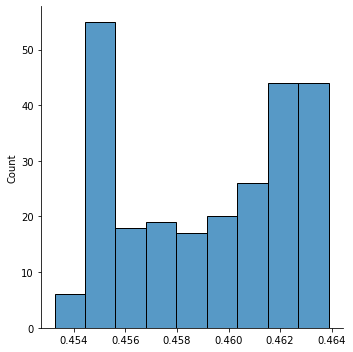

In [ ]:
sns.displot(t[0])

In [ ]:
# Para 2016
dfClassifier = pd.concat([data['1w target'][(data.index.year == 2016)].reset_index(drop=True).copy(),pd.Series(t[0])],axis=1)

In [ ]:
dfClassifier.columns = ['1w target', 'predict']

In [ ]:
dfClassifier.head()

,1w target,predict
0,0.948008,0.455029
1,0.931517,0.454685
2,0.932277,0.454638
3,0.970635,0.454705
4,0.949695,0.455321


In [ ]:
dfClassifier['target'] = dfClassifier['1w target'].apply(lambda x: 1 if x > 1.0 else 0)

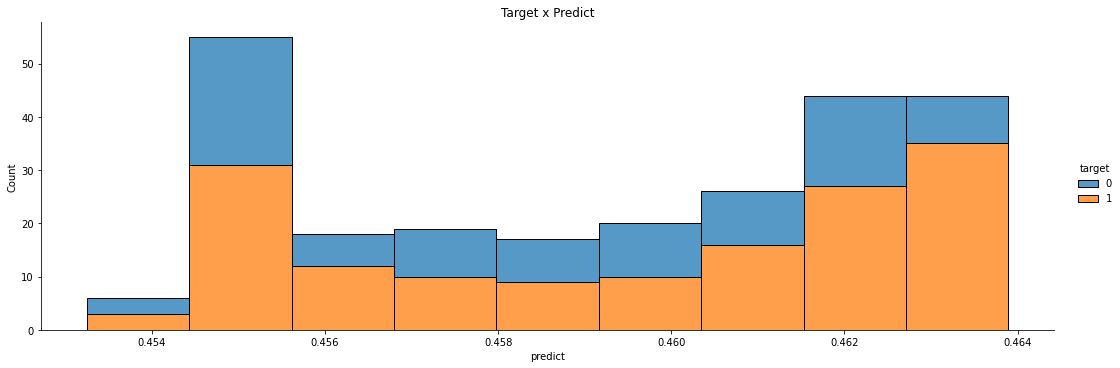

In [ ]:
ax = sns.displot(dfClassifier,x='predict',hue='target',aspect=3, multiple="stack").set(title='Target x Predict')

In [ ]:
roc_auc_score(dfClassifier['target'],dfClassifier['predict'])

0.5813589324618736

In [ ]:
def limiar_escore(predictions,df_target):
    #Imprimindo limiar de Escore
    fpr, tpr, threshold = roc_curve(df_target, predictions)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',np.round(Precision,4))
    print('Recall',np.round(Recall,4))
    print('Acuracia',np.round(acuracia,4))
    print('F-Score',np.round(F,4))
    print('Roc-Auc',np.round(roc_auc_score(df_target,predictions),4))

In [ ]:
limiar_escore(dfClassifier['predict'],dfClassifier['target'])

Limiar que maxima especificidade e sensitividade:
[0.4597029983997345]
Precision 0.6641
Recall 0.5556
Acuracia 0.5542
F-Score 0.605
Roc-Auc 0.5814


In [ ]:
scaler = Normalizer()
scaler.fit(np.array(realy).reshape(-1, 1))
t = scaler.transform(np.array([ i for i in predictions_LSTM[2016]['Predictions'].values]).reshape(1, -1))

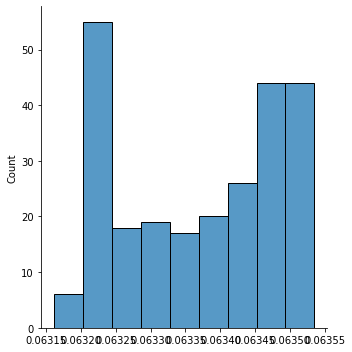

In [ ]:
sns.displot(t[0])